# Working with SeismicDataset
Seismic dataset contains functions that calculate some parameters for the dataset.

* [Find parameters for spherical divergence correction](#Find-parameters-for-spherical-divergence-correction)

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('..')

from seismicpro.batchflow import Pipeline, V, D, B
from seismicpro.src import (SeismicDataset, FieldIndex, CustomIndex,
                            calculate_sdc_quality, avo_plot)

First of all we have to create an index.

In [2]:
path_raw = '/data/SD/dataset_1/2_TAR_raw.sgy'

field_index = FieldIndex(name='raw', extra_headers=['offset'], path=path_raw)

Based on indexd and dataset one can create a dataset instance.

In [3]:
dataset = SeismicDataset(field_index)

## Find parameters for spherical divergence correction
Spherical divergence correction action from ```SeismicBatch``` takes parameters based on which correction will be made. These parameters could be found for all dataset by ```find_sdc_params``` function. It uses speed, time and loss function to find optimal parameters for spherical divergence correction. In this example, speed was calculated by a specialist. By default, time takes from ```meta``` comonent.

In [4]:
speed = np.array([1524]*700 + [1924.5]*300 + [2184.0]*400 +  [2339.6]*400 + 
                 [2676]*150 + [2889.5]*2250 + [3566]*2800 + [4785.3]*1000)

Following line run optimization process. This process works with scipy optimization, so you can specify any parameters from ```scipy.optimize.minimize```. The optimization process takes a lot of time, this why it's calculated once for all dataset.

In [5]:
parameters = dataset.find_sdc_params(component='raw', speed=speed,
                                     loss=calculate_sdc_quality)

Founded parameters will be saved to the variable named ```parameters```.

In [6]:
print('Optimal parameters for v_pow is {:.3}, for t_pow is {:.3}.'.format(*parameters))

Optimal parameters for v_pow is 2.06, for t_pow is 0.998.


More frequently this function will be used to calculate parameters once before main preprocessing pipeline. An example how to use ```pipeline.before``` to find  parameters for spherical divergence correction shown in [model_description](../models/Spherical_divergence_correction/model_description.ipynb).

## Amplitude versus offset
AVO calculates among all dataset. Based on prior knowledge about dataset it is important to specify the type of the data. If all seismograms in dataset have same size and same offsets, use parameter `'same'` in `field_type` argument, otherwise use `'diff'`. In addition, it needed to add class size and window in ms/s where AVO will be calculated.

Here we will consider 3 typos of data:
1. Dataset with `'same'` type of seismograms.
2. Dataset with `'diff'` type of seismograms.
3. Dataset with `'diff'` type of seismograms with given horizon instead of window parameter.

__NOTE:__ It is important to add `CROSSLINE_3D` and `INLINE_3D` headers when use horizon.

Before, we will create indices for all datasets:

In [7]:
path_same = '/data/H2_PAL/AVO/H2_PAL_4_avo_cdp_int5d.sgy'
path_diff = '/data/H2_PAL/AVO/H2_PAL_4_avo_cdp_17-lift.sgy'
path_hor_data = '/data/H2_PAL/AVO/H2_PAL_4_avo_cdp_17-lift_No_Time_Shift.sgy'
path_horizon = '/data/H2_PAL/AVO/MS_J0_for_QC_avo.txt'

index_same = FieldIndex(name='raw', extra_headers=['offset', 'CDP'], path=path_same)
ix_same = CustomIndex(index_same, index_name='CDP')

index_diff = FieldIndex(name='lift', extra_headers=['offset', 'CDP'], path=path_diff)
ix_diff = CustomIndex(index_diff, index_name='CDP')

index_hor = FieldIndex(name='raw', extra_headers=['offset', 'CDP',
                                                  'CROSSLINE_3D', 
                                                  'INLINE_3D'], path=path_hor_data)
ix_hor = CustomIndex(index_hor, index_name='CDP')

And create datasets.

In [8]:
avo_dataset_same = SeismicDataset(ix_same)
avo_dataset_diff = SeismicDataset(ix_diff)
avo_dataset_hor = SeismicDataset(ix_hor)

##### AVO distribution for constant field shape and offsets.
This data contains fileds with same number of traces and same ranges of offsets. Number of traces in one field is 113, offset range is 3498.

All calculated amplitudes will be saved to dataset component with `container_name`. After running calculating AVO among all dataset we will plot the result using `avo_plot` function.

In [9]:
same_pipeline = (avo_dataset_same.p
     .load(fmt='segy', components='raw')
     .sort_traces(src='raw', dst='raw', sort_by='offset')
     .find_avo_distribution(B(), component='raw', class_size=100,
                            window=[1960, 1980], container_name='avo_classes')
     .run_later(batch_size=1, n_epochs=1, shuffle=False, 
                drop_last=False, bar=True)
)

(same_pipeline.after
              .avo_plot(D('avo_classes'), figsize=(15, 7), amp_size=1,
                        rms_size=50, class_size=100, title='AVO same')
);

Run pipeline and draw resulted AVO.

100%|██████████| 551/551 [00:33<00:00, 16.41it/s]
../seismicpro/src/plot_utils.py:539: RuntimeWarning: Mean of empty slice
  rms = np.nanmean(nan_data**2, axis=1)**.5


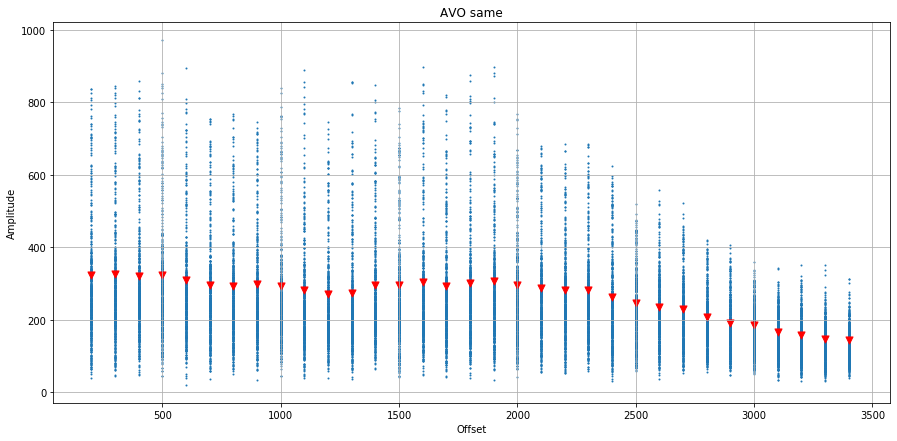

In [10]:
same_pipeline.run();

##### AVO distribution for different field shape and offsets.
Data contains fileds with a large spread of shapes, from 30 to 111 traces in one field. Offset also different, from 3087 to 3500.

The same notation continues here, only the `field_type` argument is different.

In [11]:
diff_pipeline = (avo_dataset_diff.p
         .load(fmt='segy', components='lift', tslice=slice(3000))
         .sort_traces(src='lift', dst='lift', sort_by='offset')
         .find_avo_distribution(B(), component='lift', class_size=100,
                                window=[1970, 1980], field_type='diff',
                                field_ratio=10, container_name='avo_classes')
         .run_later(batch_size=20, n_epochs=1, shuffle=False, 
                    drop_last=False, bar=True)
         )

(diff_pipeline.after
             .avo_plot(D('avo_classes'), figsize=(15, 7), amp_size=3,
                       rms_size=50, class_size=100, title='AVO lift'));

100%|██████████| 28/28 [00:11<00:00,  2.46it/s]


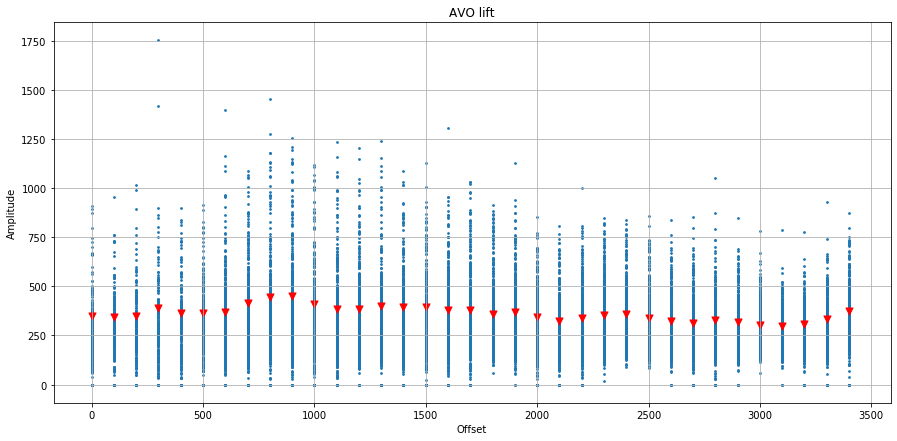

In [12]:
diff_pipeline.run();

##### AVO distribution for horizon.
This dataset contains 551 seismograms with min shape = 30 and max shape = 111. Offsets vary from 34 to 3500. To use horizon instead of window, just use `horizon` argument. Note, `horizon` takes priority over `window` argument.

In [13]:
hor_pipeline = (avo_dataset_hor.p     
    .load(fmt='segy', components='raw', tslice=slice(3000))
         .sort_traces(src='raw', dst='raw', sort_by='offset')
         .find_avo_distribution(B(), component='raw', class_size=100, 
                                field_type='diff', field_ratio=10,
                                horizon=path_horizon, container_name='avo_classes')
         .run_later(batch_size=20, n_epochs=1, shuffle=False, 
                    drop_last=False, bar=True)
         )

(hor_pipeline.after
             .avo_plot(D('avo_classes'), figsize=(15, 7), amp_size=1,
                       rms_size=50, class_size=100, title='AVO raw'));

100%|██████████| 28/28 [00:15<00:00,  1.75it/s]


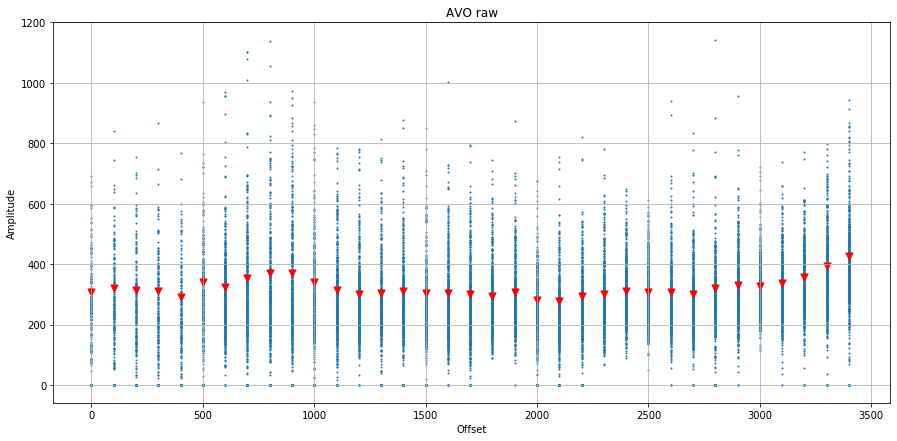

In [14]:
hor_pipeline.run();